# Modelo de submuestreo

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib.pyplot as plt2
import os
from os import listdir
from os.path import isfile, join
from skimage import io
import random

## <font color=red>1. </font>Cargar las imágenes y los datos tabulares

In [38]:
# Resized images directories
dir_resized_train_images = "/kaggle/input/resizedsiimisic/train_resized/"
train_resized_images = [f for f in listdir(dir_resized_train_images) if isfile(join(dir_resized_train_images, f))]
# dir_resized_test_images = "/kaggle/input/siim-isic-2019/test"
# test_resized_images = [f for f in listdir(dir_resized_test_images) if isfile(join(dir_resized_test_images, f))]

# CSV files
train_df = pd.read_csv('/kaggle/input/resizedsiimisic/train.csv')
# test_df = pd.read_csv('/kaggle/input/siim-isic-2019/test.csv')

In [39]:
train_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,target
0,ISIC_2637011.jpg,IP_7279968,male,45.0,head/neck,0
1,ISIC_0015719.jpg,IP_3075186,female,45.0,upper extremity,0
2,ISIC_0052212.jpg,IP_2842074,female,50.0,lower extremity,0
3,ISIC_0068279.jpg,IP_6890425,female,45.0,head/neck,0
4,ISIC_0074268.jpg,IP_8723313,female,55.0,upper extremity,0


In [40]:
print("Train shape:", train_df.shape)
# print("Test shape:", test_df.shape)

Train shape: (32531, 6)


## <font color=red>2. </font>Submuestreo de las imágenes mayoritarias

In [41]:
train_df.target.value_counts().rename_axis('Tipo').reset_index(name='Total de muestras')

,Tipo,Total de muestras
0,0,31956
1,1,575


In [42]:
# Number of samples of majority class to delete
N = 31956-575

train_df = train_df.drop(train_df[train_df['target'].eq(0)].sample(N).index)

In [43]:
train_df.target.value_counts().rename_axis('Tipo').reset_index(name='Total de muestras')

,Tipo,Total de muestras
0,0,575
1,1,575


In [44]:
train_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,target
33,ISIC_0086632.jpg,IP_2114130,male,40.0,torso,0
48,ISIC_0094755.jpg,IP_0135517,female,50.0,lower extremity,0
83,ISIC_0148643.jpg,IP_5776149,female,70.0,torso,0
88,ISIC_0149568.jpg,IP_0962375,female,55.0,upper extremity,1
105,ISIC_0154870.jpg,IP_6808872,male,30.0,torso,0


In [45]:
from collections import Counter
from sklearn.model_selection import train_test_split

X = train_df
y = train_df['target']

In [46]:
# Split into train, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    stratify=y,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.2,
                                                  stratify=y_train,
                                                  random_state=42)
    

print("Conjunto de train:", X_train.shape)
print("Conjunto de validacion:", X_val.shape)
print("Conjunto de prueba:", X_test.shape)
print("-----------------------")
print('Distribucion de train ->', Counter(y_train))
print('Distribucion de validacion ->', Counter(y_val))
print("Distribucion de prueba:", Counter(y_test))

Conjunto de train: (736, 6)
Conjunto de validacion: (184, 6)
Conjunto de prueba: (230, 6)
-----------------------
Distribucion de train -> Counter({1: 368, 0: 368})
Distribucion de validacion -> Counter({0: 92, 1: 92})
Distribucion de prueba: Counter({0: 115, 1: 115})


In [47]:
def check_for_leakage(df1, df2, patient_col):
    df1_patients_unique = set(df1[patient_col].values)
    df2_patients_unique = set(df2[patient_col].values)
    
    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique)

    # Leakage contains true if there is patient overlap, otherwise false
    leakage = len(patients_in_both_groups) > 0 # boolean (true if there is at least 1 patient in both groups)
    return leakage

In [48]:
check_for_leakage(X_train, X_test, 'patient_id')

True

#### A continuación, se elimina la columna de 'patient_id' una vez comprobado el Data Leakage.

In [49]:
train_df = train_df.drop(columns=['patient_id'])

In [50]:
X_train["target"] = X_train['target'].astype(str)
X_val["target"] = X_val['target'].astype(str)
X_test["target"] = X_test['target'].astype(str)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## <font color=red>3. </font>Crear y entrenar el modelo

In [51]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import ResNet50V2, EfficientNetB0
from tensorflow.keras.applications import DenseNet121 # input size 224x224
from tensorflow.keras.layers import Dense, Dropout, Flatten, SpatialDropout2D, SpatialDropout1D, AlphaDropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

PATH = dir_resized_train_images

2021-11-14 20:23:44.374714: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [52]:
train_datagen=ImageDataGenerator(rescale=1./255.)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=X_train,
    directory=dir_resized_train_images,
    x_col="image_name",
    y_col="target",
    subset="training",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="binary"
)

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=X_val,
    directory=dir_resized_train_images,
    x_col="image_name",
    y_col="target",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="binary"
)

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
    dataframe=X_test,
    directory=dir_resized_train_images,
    x_col="image_name",
    y_col="target",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode="binary"
)

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

Found 736 validated image filenames belonging to 2 classes.
Found 184 validated image filenames belonging to 2 classes.
Found 230 validated image filenames belonging to 2 classes.


In [53]:
print("Original train images:", len(train_df))
# print("Original test images:", len(test_df))

Original train images: 1150


In [54]:
encoder = DenseNet121(input_shape=(None,None,3), 
                      include_top=False, 
                      weights='imagenet')

2021-11-14 20:23:48.292071: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-14 20:23:48.295594: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-14 20:23:48.342117: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-14 20:23:48.342797: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-11-14 20:23:48.342879: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-11-14 20:23:48.369849: I tensorflow/stream_executor/platform/def

29089792/29084464 [==============================] - 0s 0us/step


In [55]:
for layer in encoder.layers:
    layer.trainable = False

inputs = keras.Input(shape=(None, None, 3))
x = encoder(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid')(x)
model_undersampling = Model(inputs=inputs, outputs=predictions)

In [56]:
model_undersampling.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 1,025
Non-trainable params: 7,037,504
_________________________________________________________________


In [57]:
checkpoint_filepath = '/kaggle/working/model.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                            save_weights_only=True,
                                                            monitor='val_auc',
                                                            mode='max',
                                                            verbose=1,
                                                            save_best_only=True)

In [58]:
class LossLearningRateScheduler(tf.keras.callbacks.History):
    """
    base_lr: the starting learning rate
    lookback_epochs: the number of epochs in the past to compare with the loss function at the current epoch to determine if progress is being made.
    decay_threshold / decay_multiple: if loss function has not improved by a factor of decay_threshold * lookback_epochs, then decay_multiple will be applied to the learning rate.
    spike_epochs: list of the epoch numbers where you want to spike the learning rate.
    spike_multiple: the multiple applied to the current learning rate for a spike.
    """
    
    def __init__(self, base_lr, lookback_epochs, spike_epochs = None, spike_multiple = 10, decay_threshold = 0.002, decay_multiple = 0.7, loss_type = 'val_loss'):
        super(LossLearningRateScheduler, self).__init__()
        self.base_lr = base_lr
        self.lookback_epochs = lookback_epochs
        self.spike_epochs = spike_epochs
        self.spike_multiple = spike_multiple
        self.decay_threshold = decay_threshold
        self.decay_multiple = decay_multiple
        self.loss_type = loss_type


    def on_epoch_begin(self, epoch, logs=None):
        if len(self.epoch) > self.lookback_epochs:
            current_lr = tf.keras.backend.get_value(self.model.optimizer.lr)
            target_loss = self.history[self.loss_type] 
            loss_diff =  target_loss[-int(self.lookback_epochs)] - target_loss[-1]

            if loss_diff <= np.abs(target_loss[-1]) * (self.decay_threshold * self.lookback_epochs):
                print(' '.join(('Changing learning rate from', str(current_lr), 'to', str(current_lr * self.decay_multiple))))
                tf.keras.backend.set_value(self.model.optimizer.lr, current_lr * self.decay_multiple)
                current_lr = current_lr * self.decay_multiple
            else:
                print(' '.join(('Learning rate:', str(current_lr))))

            if self.spike_epochs is not None and len(self.epoch) in self.spike_epochs:
                print(' '.join(('Spiking learning rate from', str(current_lr), 'to', str(current_lr * self.spike_multiple))))
                tf.keras.backend.set_value(self.model.optimizer.lr, current_lr * self.spike_multiple)
        else:
            print(' '.join(('Setting learning rate to', str(self.base_lr))))
            tf.keras.backend.set_value(self.model.optimizer.lr, self.base_lr)

        return tf.keras.backend.get_value(self.model.optimizer.lr)

lr_callback = LossLearningRateScheduler(base_lr=0.1, lookback_epochs=3)

In [59]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.AUC(name='auc'),
]

In [60]:
model_undersampling.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.1),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS
)

In [61]:
history = model_undersampling.fit(train_generator, 
                                  validation_data=valid_generator,
                                  steps_per_epoch=STEP_SIZE_TRAIN, 
                                  validation_steps=STEP_SIZE_VALID,
                                  callbacks=[model_checkpoint_callback, lr_callback],
                                  # use_multiprocessing=True,
                                  epochs = 100)

2021-11-14 20:23:54.336672: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-14 20:23:54.340398: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000165000 Hz


Epoch 1/100
Setting learning rate to 0.1


2021-11-14 20:24:00.909897: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-11-14 20:24:01.722286: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-11-14 20:24:01.768484: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


23/23 [==============================] - 19s 279ms/step - loss: 3.6121 - tp: 114.5417 - fp: 89.2500 - tn: 106.9583 - fn: 87.9167 - auc: 0.5566 - val_loss: 1.1192 - val_tp: 52.0000 - val_fp: 10.0000 - val_tn: 67.0000 - val_fn: 31.0000 - val_auc: 0.8197

Epoch 00001: val_auc improved from -inf to 0.81975, saving model to /kaggle/working/model.h5
Epoch 2/100
Setting learning rate to 0.1
23/23 [==============================] - 2s 104ms/step - loss: 0.8866 - tp: 143.9583 - fp: 56.2083 - tn: 150.0417 - fn: 48.4583 - auc: 0.7994 - val_loss: 0.8997 - val_tp: 71.0000 - val_fp: 33.0000 - val_tn: 44.0000 - val_fn: 12.0000 - val_auc: 0.8126

Epoch 00002: val_auc did not improve from 0.81975
Epoch 3/100
Setting learning rate to 0.1
23/23 [==============================] - 3s 116ms/step - loss: 0.7276 - tp: 143.5417 - fp: 49.6250 - tn: 149.0000 - fn: 56.5000 - auc: 0.8090 - val_loss: 0.7962 - val_tp: 59.0000 - val_fp: 20.0000 - val_tn: 64.0000 - val_fn: 17.0000 - val_auc: 0.8513

Epoch 00003: val_a

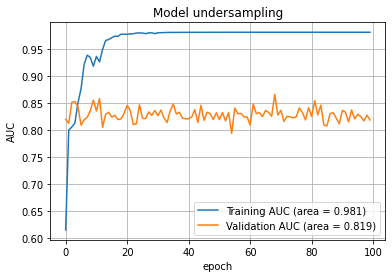

In [62]:
plt.plot(history.history['auc'], 
         label='Training AUC (area = {:.3f})'.format(history.history['auc'][-1]))
plt.plot(history.history['val_auc'], 
         label='Validation AUC (area = {:.3f})'.format(history.history['val_auc'][-1]))
plt.title('Model undersampling')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.grid()
plt.legend(loc='best')

plt.show()

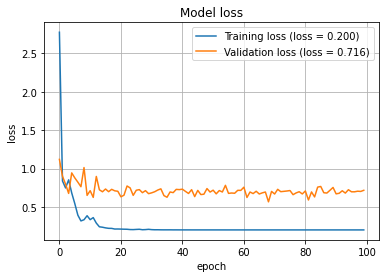

In [63]:
plt.plot(history.history['loss'], label='Training loss (loss = {:.3f})'.format(history.history['loss'][-1]))
plt.plot(history.history['val_loss'], label='Validation loss (loss = {:.3f})'.format(history.history['val_loss'][-1]))
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(loc='best')

plt.show()

## <font color=red>4. </font>Evaluar el modelo

In [64]:
eval_metrics = model_undersampling.evaluate(test_generator,
                                            steps=STEP_SIZE_TEST,
                                            return_dict=True,
                                            use_multiprocessing=False,
                                            verbose=1)

7/7 [==============================] - 1s 165ms/step - loss: 0.6350 - tp: 82.0000 - fp: 23.0000 - tn: 88.0000 - fn: 31.0000 - auc: 0.8374


#### Se obtiene las predicciones y las etiquetas del conjunto de prueba.

In [65]:
true_labels = test_generator.classes
predict = model_undersampling.predict(test_generator, 
                                      verbose=1)

8/8 [==============================] - 3s 125ms/step


#### Finalmente, se observa la curva ROC-AUC y la matriz de confusión.

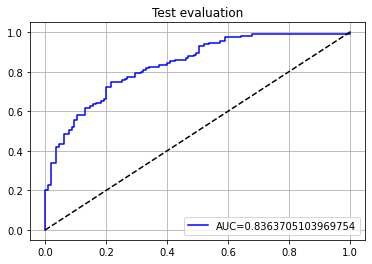

In [66]:
from sklearn import metrics
import scikitplot as skplt

fpr, tpr, tr = metrics.roc_curve(true_labels,predict)
auc = metrics.roc_auc_score(true_labels, predict)
plt.plot(fpr,tpr,'b',label="AUC="+str(auc))
plt.plot([0,1],[0,1],'k--')
plt.title('Test evaluation')
plt.grid()
plt.legend(loc='best')
plt.show()

<AxesSubplot:>

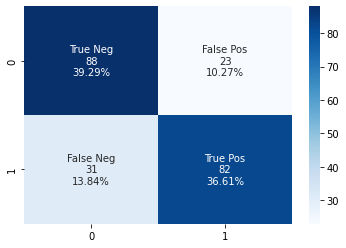

In [67]:
import seaborn as sns

cm = [eval_metrics['tn'],eval_metrics['fp'],eval_metrics['fn'],eval_metrics['tp']]

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm]
group_percentages = ["{0:.2%}".format(value) for value in cm/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap([[cm[0], cm[1]], [cm[2], cm[3]]], annot=labels, fmt='', cmap='Blues')